<br>
<br>
<br>
<font size=6>Предсказание оттока пользователей</font>
<br>
<br>
<br>
Это соревнование является домашним заданием к 3 модулю продвинутого потока DLS.<br>
Вам предстоит научиться моделировать отток клиентов телеком компании.<br>
Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, <br>
ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаемся удержать его, предложив какие-то бонусы.<br>
<br>
<br>
<br>
Ссылка на <a href='https://www.kaggle.com/competitions/advanced-dls-spring-2021/data'>датасет.</a>
<br><br>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<br>
<font size=6>Эпизод Ⅰ</font><br>
<br>
<font size=5>Исследование</font>
<hr>

<br>
<font size=4><b>Загрузка данных</b></font>
<br><br>

In [18]:
data_train = pd.read_csv('data/churn_dataset/train.csv')
print(f'Objects: {data_train.shape[0]}')
print(f'Features: {data_train.shape[1]}')
data_train.head()

Objects: 5282
Features: 20


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [16]:
data_test = pd.read_csv('data/churn_dataset/test.csv')
print(f'Objects: {data_test.shape[0]}')
print(f'Features: {data_test.shape[1]}')
data_test.head()

Objects: 1761
Features: 19


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


<br>
<font size=4><b>Exploratory data analysis</b></font>
<br><br>

<br>
Начнем с изучения признаков.<br>
Признаки довольно простые и понять какие в них значения несложно, но вопросы возникают к <b>HasInternetService</b>, <b>HasContractPhone</b>, <b>PaymentMethod</b>.
<br><br>

In [80]:
def get_series_procent(count_: pd.Series, value_counts: pd.Series) -> pd.Series:
    """ Рассчитает процент для каждого значения в серии """
    procent_list = [value/count_ for value in val_counts]
    procent_series = pd.Series(data=procent_list, index=val_counts.index)
    return procent_series

In [81]:
features_question = ['HasInternetService', 'HasContractPhone', 'PaymentMethod']

for feature in features_question:
    count_ = data_train[feature].count()
    val_counts = data_train[feature].value_counts()
    procent_series = get_series_procent(count_, val_counts)
    features_df = pd.DataFrame(
        data={
            'value_counts': val_counts,
            'procent': procent_series},
        index=val_counts.index)
    features_df.index.rename(feature, inplace=True)
    print(f'{features_df} \n\n')

                    value_counts   procent
HasInternetService                        
Fiber optic                 2341  0.443203
DSL                         1800  0.340780
No                          1141  0.216017 


                  value_counts   procent
HasContractPhone                        
Month-to-month            2920  0.552821
Two year                  1280  0.242332
One year                  1082  0.204847 


                           value_counts   procent
PaymentMethod                                    
Electronic check                   1786  0.338129
Mailed check                       1194  0.226051
Bank transfer (automatic)          1159  0.219424
Credit card (automatic)            1143  0.216395 




Все значения более-менее сбалансированы.<br>
<b>HasContractPhone</b> будем кодировать с помощью <b>Ordinal Encoding</b>, остальные категориальные признаки пойдут через <b>One-Hot Encoding</b>.

<br>
Проверим данные рандомного клиента
<br><br>

In [84]:
data_train.iloc[np.random.randint(data_train.shape[0])]

ClientPeriod                               8
MonthlySpending                        55.75
TotalSpent                             446.8
Sex                                   Female
IsSeniorCitizen                            0
HasPartner                               Yes
HasChild                                 Yes
HasPhoneService                          Yes
HasMultiplePhoneNumbers                  Yes
HasInternetService                       DSL
HasOnlineSecurityService                  No
HasOnlineBackup                          Yes
HasDeviceProtection                       No
HasTechSupportAccess                      No
HasOnlineTV                               No
HasMovieSubscription                      No
HasContractPhone              Month-to-month
IsBillingPaperless                        No
PaymentMethod               Electronic check
Churn                                      0
Name: 1432, dtype: object

<br>
Посмотрим какой тип данных принимает каждый признак
<br><br>

In [87]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

<br>
<b>TotalSpent</b> имеет тип данных 'object', но если посмотреть на датасет,<br>
то получается далеко не 'object' - это заявка на пропуск в данных.
<br><br>

<br>
<font size=3><b>Поиск пропусков</b></font>
<br><br>

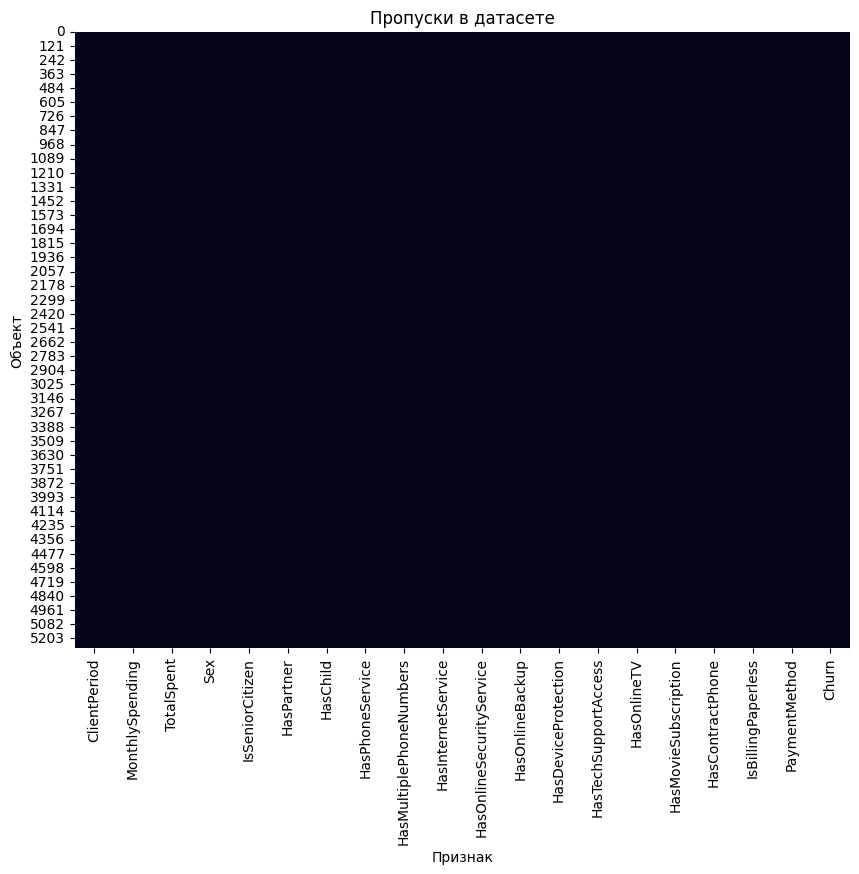

Кол-во пропусков в каждом признаке:
ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64


In [98]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_train.isnull(), cbar=False)
plt.title('Пропуски в датасете')
plt.xlabel('Признак')
plt.ylabel('Объект')
plt.show()

print('Кол-во пропусков в каждом признаке:')
print(data_train.isnull().sum())

Heatmap и количество пропусков говорят, что нет пропусков в виде NaN.

In [101]:
categorical_columns = [col for col in data_train
                       if data_train[col].dtypes == 'object']

for column in categorical_columns:
    print('-'*5, column, '-'*5)
    print(data_train[column].value_counts())
    print('\n')

----- TotalSpent -----
           9
20.2       9
19.75      8
20.05      6
19.65      6
          ..
41.85      1
4326.25    1
950.2      1
4264       1
1375.6     1
Name: TotalSpent, Length: 4978, dtype: int64


----- Sex -----
Male      2655
Female    2627
Name: Sex, dtype: int64


----- HasPartner -----
No     2705
Yes    2577
Name: HasPartner, dtype: int64


----- HasChild -----
No     3676
Yes    1606
Name: HasChild, dtype: int64


----- HasPhoneService -----
Yes    4761
No      521
Name: HasPhoneService, dtype: int64


----- HasMultiplePhoneNumbers -----
No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64


----- HasInternetService -----
Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64


----- HasOnlineSecurityService -----
No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64


----- HasOnl

У TotalSpent есть значение <b>пробела</b> вместо числа, поэтому и получился object, исправим это

In [106]:
data_train.TotalSpent.replace(' ', np.nan, inplace=True)
data_train = data_train.dropna()

Теперь пропусков в обучающем датасете нет.

<br>
Посмотрим как распределены значения числовых признаков
<br><br>

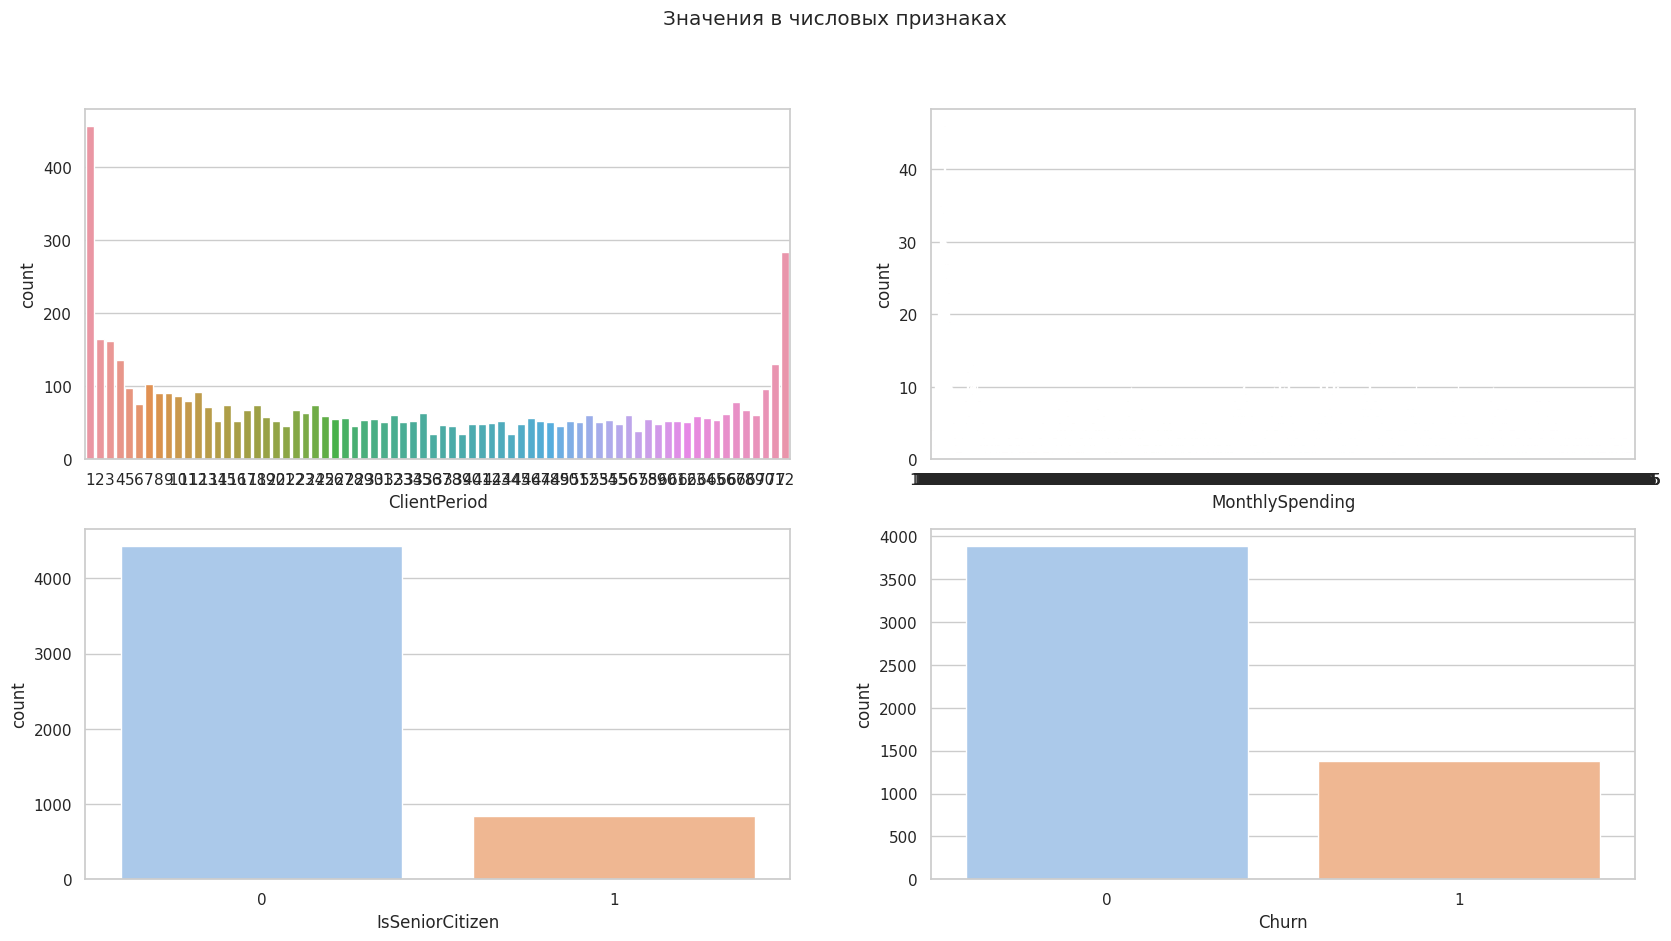

In [117]:
numerical_columns = [col for col in data_train
                     if data_train[col].dtypes in ['int64', 'float64']]

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.flatten()
fig.suptitle('Значения в числовых признаках')

sns.set_theme(style='whitegrid', palette='pastel')
for i in range(len(numerical_columns)):
    sns.countplot(ax=ax[i], x=numerical_columns[i], data=data_train)